In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

#data set path in my google drive
seg_path = '/content/drive/MyDrive/ME project segmented dataset'
categories = ['Carpetweeds','Eclipta','Morning_glory','Ragweed','Cotton']

database = []

SIZE = 224

### read the leaf images from google drive 
### then resize all images into 224 X 224 

for i in categories:
  count = 0 
  path=seg_path+'/'+ i
  for img in os.listdir(path):
      img =  plt.imread(os.path.join(path,img))
      new_array = cv2.resize(img , (SIZE,SIZE))
      database.append([new_array ,i])
      count+=1
  print("\n no of "+ i + " images : ",count)
    
print("\n total no of  images :",len(database))



 no of Carpetweeds images :  182

 no of Eclipta images :  123

 no of Morning_glory images :  272

 no of Ragweed images :  92

 no of Cotton images :  166

 total no of  images : 835


<function matplotlib.pyplot.show>

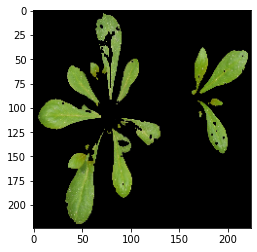

In [ ]:
plt.imshow(database[35][0])
plt.show

In [ ]:
#create 2 empty lists such as x and y for features and labels 
x=[]
y=[]

for features , label in database:
    x.append(features)
    y.append(label)

#divide the x array elements by 255
x = np.array(x)/255.0

print(x[0].shape)

print(x.shape[0], 'train samples')

(224, 224, 3)
835 train samples


In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
y = le.fit_transform(y)
print(y[0])
####   One Hot Encode the Numerical Values
y = np_utils.to_categorical(y, 5)
print(y[0])

0
[1. 0. 0. 0. 0.]


In [ ]:
### import train_test_split method to split the dataset into train and test randomly
from sklearn.model_selection import train_test_split

(trainData , testData , trainLabels , testLabels) = train_test_split(x ,y, test_size = 0.3 ,random_state = 45)

print(len(trainData))
print(len(testData))

584
251


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(
    rotation_range = 40 ,
    shear_range=0.3 ,
    zoom_range = 0.4,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode = 'nearest'
    )

train_data_gen.fit(trainData)  

In [ ]:
import tensorflow
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input,Dense,Flatten,Dropout,GlobalAveragePooling2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import img_to_array , load_img
import argparse
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard

vgg_model = VGG16(weights='imagenet',include_top=False)

vgg_model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
for layer in vgg_model.layers:
  layer.trainable = False

In [ ]:
input = Input(shape = (SIZE,SIZE,3))
output_vgg_16_conv = vgg_model(input)
x = Flatten()(output_vgg_16_conv)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(5, activation='softmax')(x)

model = Model(input ,x)

model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 40,933,189
Trainable params: 26,218,501
Non-tra

In [ ]:
model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

file_path="/content/drive/MyDrive/ME project phase 1/vgg16_weights_best(include cotton).hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

early = EarlyStopping(monitor="val_loss", mode="auto", patience=15)

callbacks_list = [checkpoint, early] #early 
history = model.fit(train_data_gen.flow(trainData, trainLabels),
                    validation_data =(testData,testLabels),
                    epochs=5,
                    verbose=1,
                    callbacks=callbacks_list
                    ) 
             

Epoch 1/5
19/19 [==============================] - ETA: 0s - loss: 4.0720 - accuracy: 0.4366
Epoch 1: val_loss improved from inf to 0.78679, saving model to /content/drive/MyDrive/ME project phase 1/vgg16_weights_best(include cotton).hdf5
19/19 [==============================] - 13s 682ms/step - loss: 4.0720 - accuracy: 0.4366 - val_loss: 0.7868 - val_accuracy: 0.7092
Epoch 2/5
19/19 [==============================] - ETA: 0s - loss: 0.6049 - accuracy: 0.7757
Epoch 2: val_loss improved from 0.78679 to 0.29322, saving model to /content/drive/MyDrive/ME project phase 1/vgg16_weights_best(include cotton).hdf5
19/19 [==============================] - 11s 599ms/step - loss: 0.6049 - accuracy: 0.7757 - val_loss: 0.2932 - val_accuracy: 0.9124
Epoch 3/5
19/19 [==============================] - ETA: 0s - loss: 0.3225 - accuracy: 0.8733
Epoch 3: val_loss improved from 0.29322 to 0.25697, saving model to /content/drive/MyDrive/ME project phase 1/vgg16_weights_best(include cotton).hdf5
19/19 [====

In [ ]:
# load weights into new model
model.load_weights("/content/drive/MyDrive/ME project phase 1/vgg16_weights_best(include cotton).hdf5")
print("Loaded model from disk")

# evaluate loaded model on test data
eval = model.evaluate(testData,testLabels)

Loaded model from disk
8/8 [==============================] - 1s 144ms/step - loss: 0.1608 - accuracy: 0.9641


ResNet50

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.initializers import glorot_uniform

base_model = ResNet50(weights= 'imagenet', include_top=False, input_shape= (SIZE,SIZE,3))

for lay in base_model.layers:
  lay.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(x)
x = Dense(256, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(x)
predictions = Dense(5, activation= 'softmax')(x)

model1 = Model(inputs = base_model.input, outputs = predictions)
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
model1.compile(loss='categorical_crossentropy',
                     optimizer='Adam',
                     metrics=['accuracy'])

file_path="/content/drive/MyDrive/ME project phase 1/resnet_50_weights_best(include cotton).hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

early = EarlyStopping(monitor="val_loss", mode="auto", patience=15)

callbacks_list = [checkpoint, early] #early

history = model1.fit(train_data_gen.flow(trainData, trainLabels),
                    validation_data =(testData,testLabels),
                    epochs=40,
                    verbose=1,
                    callbacks=callbacks_list) 

Epoch 1/40
19/19 [==============================] - ETA: 0s - loss: 11.6659 - accuracy: 0.2551
Epoch 1: val_loss improved from inf to 2.97611, saving model to /content/drive/MyDrive/ME project phase 1/resnet_50_weights_best(include cotton).hdf5
19/19 [==============================] - 15s 671ms/step - loss: 11.6659 - accuracy: 0.2551 - val_loss: 2.9761 - val_accuracy: 0.3307
Epoch 2/40
19/19 [==============================] - ETA: 0s - loss: 3.1790 - accuracy: 0.3099
Epoch 2: val_loss improved from 2.97611 to 2.18017, saving model to /content/drive/MyDrive/ME project phase 1/resnet_50_weights_best(include cotton).hdf5
19/19 [==============================] - 10s 544ms/step - loss: 3.1790 - accuracy: 0.3099 - val_loss: 2.1802 - val_accuracy: 0.1992
Epoch 3/40
19/19 [==============================] - ETA: 0s - loss: 1.8786 - accuracy: 0.3801
Epoch 3: val_loss improved from 2.18017 to 1.22693, saving model to /content/drive/MyDrive/ME project phase 1/resnet_50_weights_best(include cotton)

In [ ]:
# load weights into new model
model1.load_weights("/content/drive/MyDrive/ME project phase 1/resnet_50_weights_best(include cotton).hdf5")
print("Loaded model from disk")

# evaluate loaded model on test data
eval = model1.evaluate(testData,testLabels)

Loaded model from disk
8/8 [==============================] - 1s 97ms/step - loss: 0.5344 - accuracy: 0.8167


InceptionV3

In [ ]:
from skimage.transform import resize
from random import shuffle

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input,InceptionV3
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, Concatenate
from keras import applications

base_model = InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(SIZE, SIZE, 3))
base_model.trainable = False

add_model = Sequential()
add_model.add(base_model)
add_model.add(GlobalAveragePooling2D())
add_model.add(Flatten())
add_model.add(Dense(512,activation='relu'))
add_model.add(Dense(256,activation='relu'))
add_model.add(Dense(5, activation='softmax'))

model3 = add_model
model3.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model3.summary()

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_3 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 512)               1049088   
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 5)                 12

In [ ]:
file_path="/content/drive/MyDrive/ME project phase 1/inception_weights_best(include cotton).hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

early = EarlyStopping(monitor="val_loss", mode="auto", patience=15)

callbacks_list = [checkpoint, early] #early

history = model3.fit(train_data_gen.flow(trainData, trainLabels),
                    validation_data =(testData,testLabels),
                    epochs=2,
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/2
19/19 [==============================] - ETA: 0s - loss: 0.2774 - accuracy: 0.9007
Epoch 1: val_loss improved from inf to 0.23469, saving model to /content/drive/MyDrive/ME project phase 1/inception_weights_best(include cotton).hdf5
19/19 [==============================] - 8s 447ms/step - loss: 0.2774 - accuracy: 0.9007 - val_loss: 0.2347 - val_accuracy: 0.9243
Epoch 2/2
19/19 [==============================] - ETA: 0s - loss: 0.1963 - accuracy: 0.9349
Epoch 2: val_loss did not improve from 0.23469
19/19 [==============================] - 7s 370ms/step - loss: 0.1963 - accuracy: 0.9349 - val_loss: 0.3161 - val_accuracy: 0.8765


In [ ]:
# load weights into new model
model3.load_weights("/content/drive/MyDrive/ME project phase 1/inception_weights_best(include cotton).hdf5")
print("Loaded model from disk")

# evaluate loaded model on test data
eval = model3.evaluate(testData,testLabels)

Loaded model from disk
8/8 [==============================] - 1s 82ms/step - loss: 0.2347 - accuracy: 0.9243


**MobileNet**

In [ ]:
from keras.applications.mobilenet import MobileNet


base_model_ = MobileNet(weights='imagenet', 
                                include_top=False, 
                                input_shape=(SIZE, SIZE, 3))
base_model_.trainable = False

add_model = Sequential()
add_model.add(base_model_)
add_model.add(Flatten())
add_model.add(Dense(512,activation='relu'))
add_model.add(Dense(256,activation='relu'))
add_model.add(Dense(5, activation='softmax'))

model4 = add_model
model4.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model4.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 flatten_4 (Flatten)         (None, 50176)             0         
                                                                 
 dense_8 (Dense)             (None, 512)               25690624  
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dense_10 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 29,052,101
Trainable params: 25,823,237
N

In [ ]:
file_path="/content/drive/MyDrive/ME project phase 1/mobilenet_weights_best(include cotton).hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

early = EarlyStopping(monitor="val_loss", mode="auto", patience=15)

callbacks_list = [checkpoint, early] #early

history = model4.fit(train_data_gen.flow(trainData, trainLabels),
                    validation_data =(testData,testLabels),
                    epochs=10,
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/10
19/19 [==============================] - ETA: 0s - loss: 7.7179 - accuracy: 0.6370
Epoch 1: val_loss improved from inf to 1.13781, saving model to /content/drive/MyDrive/ME project phase 1/mobilenet_weights_best(include cotton).hdf5
19/19 [==============================] - 11s 478ms/step - loss: 7.7179 - accuracy: 0.6370 - val_loss: 1.1378 - val_accuracy: 0.8805
Epoch 2/10
19/19 [==============================] - ETA: 0s - loss: 0.9206 - accuracy: 0.8818
Epoch 2: val_loss improved from 1.13781 to 0.44129, saving model to /content/drive/MyDrive/ME project phase 1/mobilenet_weights_best(include cotton).hdf5
19/19 [==============================] - 8s 402ms/step - loss: 0.9206 - accuracy: 0.8818 - val_loss: 0.4413 - val_accuracy: 0.9442
Epoch 3/10
19/19 [==============================] - ETA: 0s - loss: 0.5250 - accuracy: 0.9366
Epoch 3: val_loss improved from 0.44129 to 0.43241, saving model to /content/drive/MyDrive/ME project phase 1/mobilenet_weights_best(include cotton).hd

In [ ]:
# load weights into new model
model4.load_weights("/content/drive/MyDrive/ME project phase 1/mobilenet_weights_best(include cotton).hdf5")
print("Loaded model from disk")

# evaluate loaded model on test data
eval = model4.evaluate(testData,testLabels)

Loaded model from disk
8/8 [==============================] - 0s 44ms/step - loss: 0.3290 - accuracy: 0.9522


**InceptionResNetV2**

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

bm = InceptionResNetV2(weights='imagenet', 
                                include_top=False, 
                                input_shape=(SIZE, SIZE, 3))
bm.trainable = False

add_model = Sequential()
add_model.add(bm)
add_model.add(Flatten())
add_model.add(Dense(512,activation='relu'))
add_model.add(Dense(256,activation='relu'))
add_model.add(Dense(5, activation='softmax'))

model5 = add_model
model5.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])
model5.summary()

219070464/219055592 [==============================] - 3s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 38400)             0         
                                                                 
 dense_11 (Dense)            (None, 512)               19661312  
                                                                 
 dense_12 (Dense)            (None, 256)               131328    
                                                                 
 dense_13 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 74,130,661
Trainable params: 19,793,925

In [ ]:
file_path="/content/drive/MyDrive/ME project phase 1/inceptiopnResnetV2_weights_best(include cotton).hdf5"

checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

early = EarlyStopping(monitor="val_loss", mode="auto", patience=15)

callbacks_list = [checkpoint, early] #early

history = model5.fit(train_data_gen.flow(trainData, trainLabels),
                    validation_data =(testData,testLabels),
                    epochs=20,
                    verbose=1,
                    callbacks=callbacks_list)


Epoch 1/20
19/19 [==============================] - ETA: 0s - loss: 10.3608 - accuracy: 0.4983
Epoch 1: val_loss improved from inf to 0.93445, saving model to /content/drive/MyDrive/ME project phase 1/inceptiopnResnetV2_weights_best(include cotton).hdf5
19/19 [==============================] - 27s 820ms/step - loss: 10.3608 - accuracy: 0.4983 - val_loss: 0.9345 - val_accuracy: 0.8367
Epoch 2/20
19/19 [==============================] - ETA: 0s - loss: 1.2634 - accuracy: 0.8236
Epoch 2: val_loss improved from 0.93445 to 0.91439, saving model to /content/drive/MyDrive/ME project phase 1/inceptiopnResnetV2_weights_best(include cotton).hdf5
19/19 [==============================] - 11s 578ms/step - loss: 1.2634 - accuracy: 0.8236 - val_loss: 0.9144 - val_accuracy: 0.8406
Epoch 3/20
19/19 [==============================] - ETA: 0s - loss: 0.7585 - accuracy: 0.8596
Epoch 3: val_loss improved from 0.91439 to 0.47526, saving model to /content/drive/MyDrive/ME project phase 1/inceptiopnResnetV2_w

In [ ]:
# load weights into new model
model5.load_weights("/content/drive/MyDrive/ME project phase 1/inceptiopnResnetV2_weights_best(include cotton).hdf5")
print("Loaded model from disk")

# evaluate loaded model on test data
eval = model5.evaluate(testData,testLabels)

Loaded model from disk
8/8 [==============================] - 1s 175ms/step - loss: 0.1566 - accuracy: 0.9641
